In [2]:
import sys
import glob
import os
import re
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as mtick
%matplotlib inline

In [31]:
def cold_cache(parts):
    remove = ["cache=cold", "cache=hot"]
    result = None
    if "cache=cold" in parts:
        result = True
    else:
        result = False
    parts = filter(lambda v: v not in remove, parts)
    return result, parts
    
def process_line(line):
    ignore = ["/usr/bin/run-query", "--quiet", "run-1", "run-2", "run-3", "run-4"]
    if line[:18] != "/usr/bin/run-query":
        return None
    parts = line.split()
    parts = filter(lambda v: v not in ignore, parts)
    # runtime
    runtime = float(parts[-1])
    parts = parts[:-1]
    # use cls
    uses_cls, uses_idx, parts = uses(parts)
    is_cold_cache, parts = cold_cache(parts)
    # convert to key/value pairs
    assert len(parts) % 2 == 0
    res = {'runtime': runtime, 'cls': uses_cls, 'idx': uses_idx, 'coldcache': is_cold_cache}
    pit = iter(parts)
    for key in pit:
        assert key[:2] == "--"
        key = key[2:]
        val = next(pit)
        try:
            val = float(val)
        except:
            pass
        res.update({key:val})
    if 'extended-price' in res:
        res.update({'sel': get_sel(res["extended-price"])})
    elif 'comment_regex' in res:
        res.update({'sel': get_sel2(res["comment_regex"])})
    else:
        res.update({'sel': -1.0})
    return res

def load_traces(fnpat):
    for fn in glob.glob(fnpat):
        print fn, fnpat
        with open(fn, 'r') as f:
            results = filter(None, map(process_line, f.readlines()))
            return pd.DataFrame(results)

def combine_traces(*fns):
    fnit = iter(fns)
    dfs = []
    for fn in fnit:
        df = load_traces(fn)
        df["nosds"] = next(fnit)
        dfs.append(df)
    return pd.concat(dfs)

df = combine_traces("dev-partitioned-1osd.log", 1, "dev-partitioned-2osd.log", 2, \
                    "dev-partitioned-3osd.log", 3, "dev-partitioned-4osd.log", 4)
del df['extended-price']
del df['num-objs']
del df['pool']
del df['query'] # only b
del df['sel']
del df['idx']

dev-partitioned-1osd.log dev-partitioned-1osd.log
dev-partitioned-2osd.log dev-partitioned-2osd.log
dev-partitioned-3osd.log dev-partitioned-3osd.log
dev-partitioned-4osd.log dev-partitioned-4osd.log


In [87]:
df = df.groupby(['cls', 'nosds', 'nthreads', 'coldcache']).mean().reset_index()

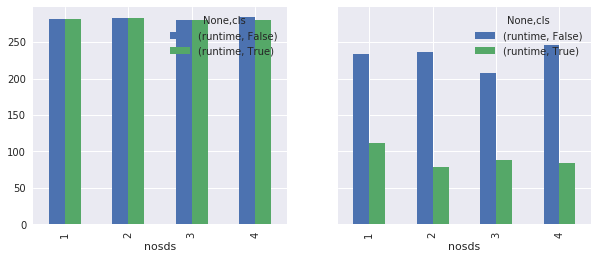

In [62]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,4))

df2 = df[(df["nthreads"] == 20.0) & (df["coldcache"] == True)]
#df2["runtime2"] = df2["runtime"] / 10000.0
#print df2
del df2["nthreads"]
del df2["coldcache"]
df2.set_index(["cls", "nosds"]).unstack(0).plot.bar(ax=ax[0])

df2 = df[(df["nthreads"] == 20.0) & (df["coldcache"] == False)]
#df2["runtime2"] = df2["runtime"] / 10000.0
#print df2
del df2["nthreads"]
del df2["coldcache"]
df2.set_index(["cls", "nosds"]).unstack(0).plot.bar(ax=ax[1])

# in the cold cache case both cls and non-cls run about the same time
# primarily because the cost of reading from disk dominates, even when sending less data back.
# for the hot cache case the non-cls version runs moderately faster because we tend to
# hit the cache (but the data set doesn't fit, so there is a workload specific effect in the cache hit rate).
# but... why is the cls effect so large in hot cache but not in cold? because the results below
# seem to suggest in the hot cache case that sending less data is a benefit?
# hypothesis: it isn't sending less data that makes it faster, its better cache utilization. the
# idea is that since the dataset doesn't fit into memory, in non-cls/hot-cache case an additional 120GB
# must make it through memory (network stack, osd heap) etc... in addition to the page cache.
# with cls, its just "90% less contention for memory".... the cache effects are already on edge because
# its full and we read objects 1..10K then 1..10K which is worst case scenario for LRU.

# its not only sending less data on the network. the benefit is less conention for
# shared resources on the storage machine.

# left side: why not see any change? cause we are running disk at max bandwidth

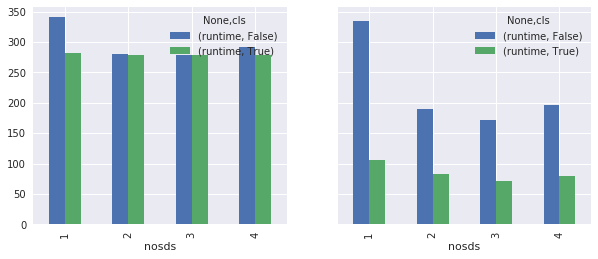

In [63]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,4))

df2 = df[(df["nthreads"] == 40.0) & (df["coldcache"] == True)]
del df2["nthreads"]
del df2["coldcache"]
df2.set_index(["cls", "nosds"]).unstack(0).plot.bar(ax=ax[0])

df2 = df[(df["nthreads"] == 40.0) & (df["coldcache"] == False)]
del df2["nthreads"]
del df2["coldcache"]
df2.set_index(["cls", "nosds"]).unstack(0).plot.bar(ax=ax[1])

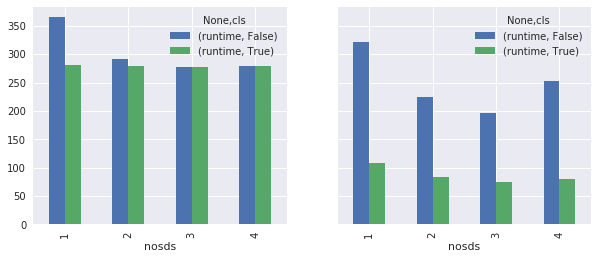

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,4))

df2 = df[(df["nthreads"] == 60.0) & (df["coldcache"] == True)]
del df2["nthreads"]
del df2["coldcache"]
df2.set_index(["cls", "nosds"]).unstack(0).plot.bar(ax=ax[0])

df2 = df[(df["nthreads"] == 60.0) & (df["coldcache"] == False)]
del df2["nthreads"]
del df2["coldcache"]
df2 = df[(df["nthreads"] == 60.0) & (df["coldcache"] == True)]
df2.set_index(["cls", "nosds"]).unstack(0).plot.bar(ax=ax[1])

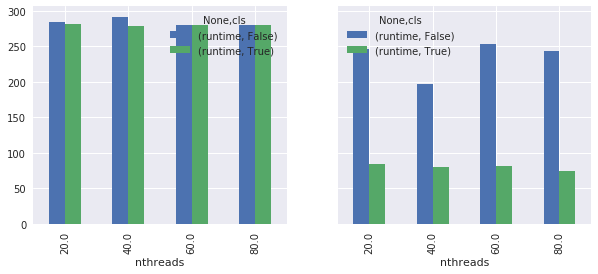

In [70]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,4))

df2 = df[(df["nosds"] == 4.0) & (df["coldcache"] == True)]
del df2["coldcache"]
del df2["nosds"]
df2.set_index(["cls", "nthreads"]).unstack(0).plot.bar(ax=ax[0])

df2 = df[(df["nosds"] == 4.0) & (df["coldcache"] == False)]
del df2["coldcache"]
del df2["nosds"]
df2.set_index(["cls", "nthreads"]).unstack(0).plot.bar(ax=ax[1])

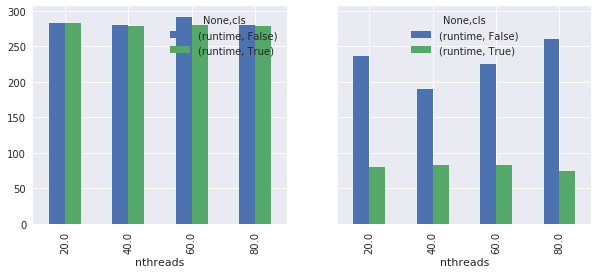

In [71]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,4))

df2 = df[(df["nosds"] == 2.0) & (df["coldcache"] == True)]
del df2["coldcache"]
del df2["nosds"]
df2.set_index(["cls", "nthreads"]).unstack(0).plot.bar(ax=ax[0])

df2 = df[(df["nosds"] == 2.0) & (df["coldcache"] == False)]
del df2["coldcache"]
del df2["nosds"]
df2.set_index(["cls", "nthreads"]).unstack(0).plot.bar(ax=ax[1])

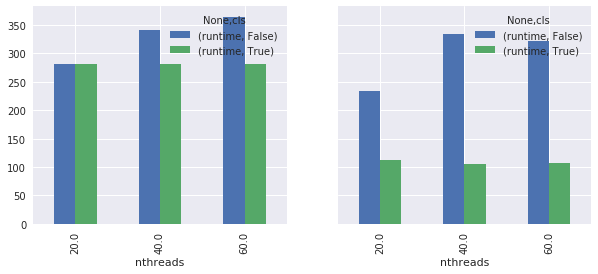

In [72]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,4))

df2 = df[(df["nosds"] == 1.0) & (df["coldcache"] == True)]
del df2["coldcache"]
del df2["nosds"]
df2.set_index(["cls", "nthreads"]).unstack(0).plot.bar(ax=ax[0])

df2 = df[(df["nosds"] == 1.0) & (df["coldcache"] == False)]
del df2["coldcache"]
del df2["nosds"]
df2.set_index(["cls", "nthreads"]).unstack(0).plot.bar(ax=ax[1])

/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


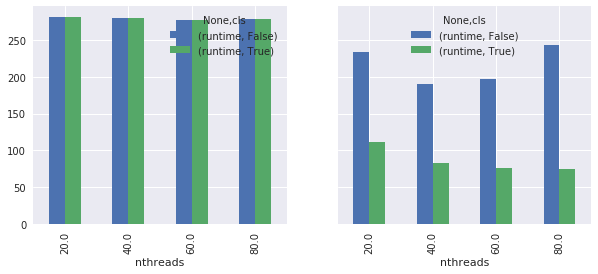

In [86]:
dfs = []
for nosds, nthreads in ((1,20), (2,40), (3,60), (4,80)):
    x = df[(df.nosds == nosds) & (df.nthreads == nthreads)]
    dfs.append(x)
df2 = pd.concat(dfs)

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,4))

df3 = df2[df["coldcache"] == True]
del df3["coldcache"]
del df3["nosds"]
df3.set_index(["cls", "nthreads"]).unstack(0).plot.bar(ax=ax[0])

df3 = df2[df["coldcache"] == False]
del df3["coldcache"]
del df3["nosds"]
df3.set_index(["cls", "nthreads"]).unstack(0).plot.bar(ax=ax[1])
